In [1]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_cleaning.create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df, prepare_for_train_test_split, create_sample_train_test
from stage_predict import stage_score_plot

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

### Load from wa_leg_staging database

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

### Create clean dataframe

In [4]:
clean = prepare_for_train_test_split(merged_final_df, bill_text_df, rep_score_df)

In [5]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,num_sections,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,bill_type,bill_type_score
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216


### Create sample and split into train and test 

In [6]:
sample_train, sample_test = create_sample_train_test(clean, n=300000)

In [7]:
null_columns=sample_test.columns[sample_test.isnull().any()]
sample_test[null_columns].isnull().sum()

first_date_read       976
secondary_sponsors    956
dtype: int64

# Modeling

### Baseline Model

In [8]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

In [9]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [10]:
y_pred_b.max()

0.9350090092524377

In [11]:
log_loss(y_test_b, y_pred_b)

0.42202030501768023

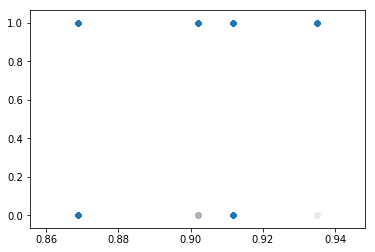

In [12]:
fig, ax = plt.subplots()
ax.scatter(y_pred_b, y_test_b, alpha=0.003)

In [13]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

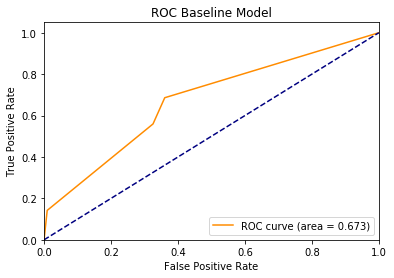

In [14]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - Random Forest

In [15]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_t = sample_test['vote']

In [16]:
top_model = RandomForestClassifier(n_estimators=1000, max_depth=11, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [17]:
log_loss(y_test_t, y_pred_t)

0.38940346451952207

In [18]:
y_pred_t.min()

0.2702420910178978

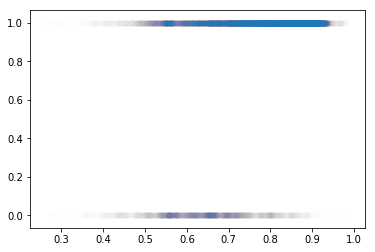

In [19]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.003)

In [20]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [21]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.8034547940598177

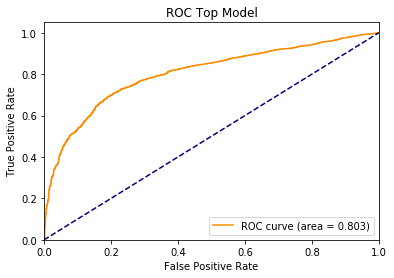

In [22]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### Trying Gradient Boosting Classifier

In [ ]:
# TRAIN
X_train_n = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_n = sample_train['vote']

# TEST
X_test_n = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_n = sample_test['vote']

In [ ]:
new_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=25, max_depth=6, random_state=709, 
                                       verbose=1)

In [ ]:
new_model.fit(X_train_n, y_train_n)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
stage_score_plot(new_model, X_train_n, y_train_n, X_test_n, y_test_n, ax)
ax.legend()
plt.show()

In [ ]:
y_pred_n = (new_model.predict_proba(X_test_n))[:, 1]

In [ ]:
log_loss(y_test_n, y_pred_n)

In [ ]:
y_pred_n.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_n, y_test_n, alpha=0.01)

In [ ]:
fpr_n, tpr_n, thresholds_n = roc_curve(y_test_n, y_pred_n)

In [ ]:
roc_auc_n = roc_auc_score(y_test_n, y_pred_n)
roc_auc_n

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr_n, tpr_n, color='darkorange', label= f'ROC curve (area = {round(roc_auc_n, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### NLP Playground

In [ ]:
my_stopwords = ['enacted', 'passed', 'pass', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [ ]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [ ]:
# bills = sample_one_year['bill_text']

In [ ]:
# wordnet = WordNetLemmatizer()

In [ ]:
# def create_bill_tokens(bill):
#     bill = bill.replace('\n', ' ') 
#     punctuations = set(string.punctuation)
    
#     bill = ''.join([char.lower() for char in bill if char not in punctuations])
#     bill_tokens = bill.split(' ')
#     lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
#     return lemmed_bill

In [ ]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [ ]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [ ]:
topic_df = topic_df.drop('biennium', axis=1)

In [ ]:
MERGED = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGED_train = MERGED[MERGED['bill_id_y'].notnull()]

In [ ]:
MERGED_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGED_test = MERGED_test[MERGED_test['bill_id_y'].notnull()]

In [ ]:
MERGED_train.columns

In [ ]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x', 'bill_id_y', 'htm_url',
                            'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                            'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                             axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x','bill_id_y', 'htm_url',
                          'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                          'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                           axis=1)

y_test = MERGD_test['vote']

In [ ]:
model = RandomForestClassifier(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted[0:20]

# Explore bill_text

In [ ]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

In [ ]:
nays.head()

In [ ]:
print(yeas.loc[3097375, 'bill_text'])

In [ ]:
print(nays.loc[2235843, 'bill_text'])